In [33]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
# Define the sigma function
def sigma(altitude):
    a = 1
    b = 0.05
    return a * (1 - np.exp(-b * altitude))


# Simulate the sensor model to create an observation matrix z
def sensor_model(true_matrix, altitude):
    sig = sigma(altitude)
    P_z_equals_m = 1 - sig
    P_z_not_equals_m = sig

    rows, cols = true_matrix.shape
    observation_matrix = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            if true_matrix[i, j] == 1:
                observation_matrix[i, j] = np.random.choice([1, 0], p=[P_z_equals_m, P_z_not_equals_m])
            else:
                observation_matrix[i, j] = np.random.choice([0, 1], p=[P_z_equals_m, P_z_not_equals_m])

    return observation_matrix

# Calculate true positive, false negative, etc.
def calculate_statistics(true_matrix, averaged_observation):
    true_positive = np.sum((true_matrix == 1) & (averaged_observation >= 0.5))
    false_negative = np.sum((true_matrix == 1) & (averaged_observation < 0.5))
    false_positive = np.sum((true_matrix == 0) & (averaged_observation >= 0.5))
    true_negative = np.sum((true_matrix == 0) & (averaged_observation < 0.5))
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    accuracy = (true_positive + true_negative) / true_matrix.size
    
    return {
        'True Positive': true_positive,
        'False Negative': false_negative,
        'False Positive': false_positive,
        'True Negative': true_negative,
        'F1 Score': f1_score,
        'Accuracy': accuracy}
# Calculate true positive, false negative, etc.
def calculate_statistics_(true_matrix, observation):
    true_positive = np.sum((true_matrix == 1) & (observation ==1))
    false_negative = np.sum((true_matrix == 1) & (observation ==0))
    false_positive = np.sum((true_matrix == 0) & (observation == 1))
    true_negative = np.sum((true_matrix == 0) & (observation ==  0))
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    accuracy = (true_positive + true_negative) / true_matrix.size
    
    return {
        'True Positive': true_positive,
        'False Negative': false_negative,
        'False Positive': false_positive,
        'True Negative': true_negative,
        'F1 Score': f1_score,
        'Accuracy': accuracy}

In [2]:
# Sample the sensor model N times and calculate the average observation matrix
def sampler_avg_obs(true_matrix, altitude, N):
    rows, cols = true_matrix.shape
    cumulative_observation = np.zeros((rows, cols))

    for _ in range(N):
        observation_matrix = sensor_model(true_matrix, altitude)
        cumulative_observation += observation_matrix
    return cumulative_observation / N

In [99]:
# Sample the sensor model N times and geenrate observation matrix
def sampler(true_matrix, altitude, N):
    cumulative_observation = np.empty((0,2))
    # cumulative_observation = np.zeros((N, rows, cols), dtype=int)
    for i in range(N):
        observation_matrix = sensor_model(true_matrix, altitude)
        cumulative_observation = np.vstack([cumulative_observation, observation_matrix])
    return cumulative_observation

In [95]:
hs = [ 5.41, 10.83, 16.24, 21.65, 27.06, 32.48]


# single cell

In [133]:
N_max = 100
N_values = list(range(1, N_max+1, 1))

true_matrix = np.array([0,1])
true_matrix = np.expand_dims(true_matrix, axis=0)
N_values = N_values[0:int(len(N_values)/2)]
N0 = N_max/2
N1 = N_max/2

In [136]:
alt_dict = {}
all_data = {}
for i, altitude in enumerate(hs):
    alt_dict={}
    for N in N_values:
        observation = sampler(true_matrix, altitude, N)
        stats = calculate_statistics_(true_matrix, observation)
        alt_dict[N]={
            "S": round(sigma(altitude),2),
            "FP": round(stats["False Positive"]/N, 2),
            "FN": round(stats["False Negative"]/N,2),
            "TN": round(stats["True Negative"]/N,2),
            "TP": round(stats["True Positive"]/N,2),
            "1-S": round(1-sigma(altitude),2),
            }
    all_data[altitude] = alt_dict
        

In [137]:
all_data

{5.41: {1: {'S': 0.24,
   'FP': 0.0,
   'FN': 0.0,
   'TN': 1.0,
   'TP': 1.0,
   '1-S': 0.76},
  2: {'S': 0.24, 'FP': 0.0, 'FN': 0.0, 'TN': 1.0, 'TP': 1.0, '1-S': 0.76},
  3: {'S': 0.24, 'FP': 0.67, 'FN': 0.33, 'TN': 0.33, 'TP': 0.67, '1-S': 0.76},
  4: {'S': 0.24, 'FP': 0.25, 'FN': 0.5, 'TN': 0.75, 'TP': 0.5, '1-S': 0.76},
  5: {'S': 0.24, 'FP': 0.0, 'FN': 0.2, 'TN': 1.0, 'TP': 0.8, '1-S': 0.76},
  6: {'S': 0.24, 'FP': 0.33, 'FN': 0.17, 'TN': 0.67, 'TP': 0.83, '1-S': 0.76},
  7: {'S': 0.24, 'FP': 0.14, 'FN': 0.29, 'TN': 0.86, 'TP': 0.71, '1-S': 0.76},
  8: {'S': 0.24, 'FP': 0.25, 'FN': 0.0, 'TN': 0.75, 'TP': 1.0, '1-S': 0.76},
  9: {'S': 0.24, 'FP': 0.33, 'FN': 0.0, 'TN': 0.67, 'TP': 1.0, '1-S': 0.76},
  10: {'S': 0.24, 'FP': 0.2, 'FN': 0.3, 'TN': 0.8, 'TP': 0.7, '1-S': 0.76},
  11: {'S': 0.24, 'FP': 0.09, 'FN': 0.36, 'TN': 0.91, 'TP': 0.64, '1-S': 0.76},
  12: {'S': 0.24, 'FP': 0.25, 'FN': 0.42, 'TN': 0.75, 'TP': 0.58, '1-S': 0.76},
  13: {'S': 0.24, 'FP': 0.08, 'FN': 0.15, 'TN': 0.

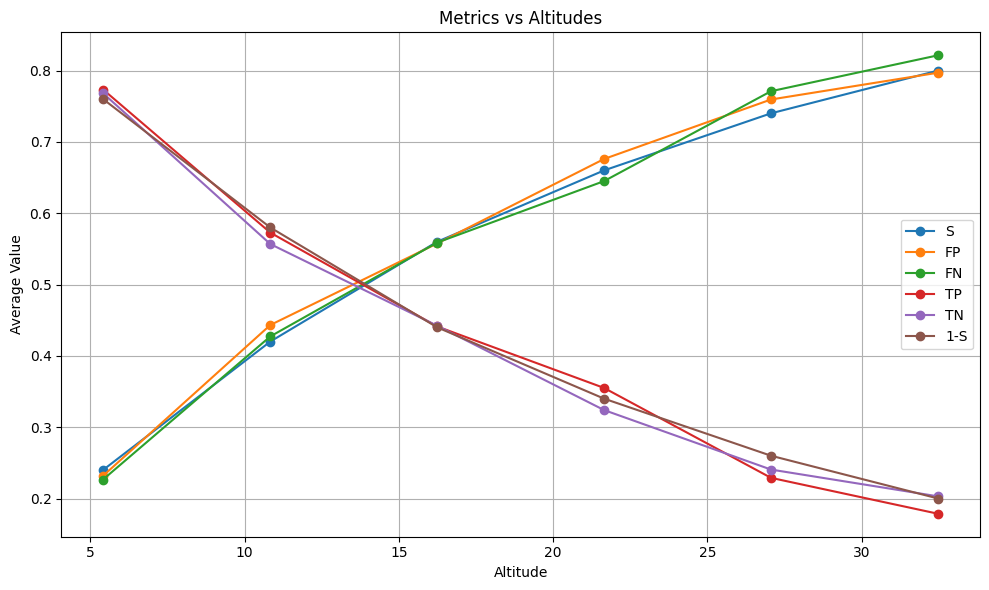

In [138]:

# Prepare data for plotting
altitudes = list(all_data.keys())
metrics = ['S', 'FP', 'FN', 'TP', 'TN', '1-S']

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over metrics to plot them
for metric in metrics:
    values = []
    for altitude in altitudes:
        samples = all_data[altitude]
        avg_metric = sum(samples[n][metric] for n in samples) / len(samples)
        values.append(avg_metric)
    ax.plot(altitudes, values, marker='o', label=metric)

# Add labels, legend, and gridall_data
ax.set_title('Metrics vs Altitudes')
ax.set_xlabel('Altitude')
ax.set_ylabel('Average Value')
ax.legend()
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()


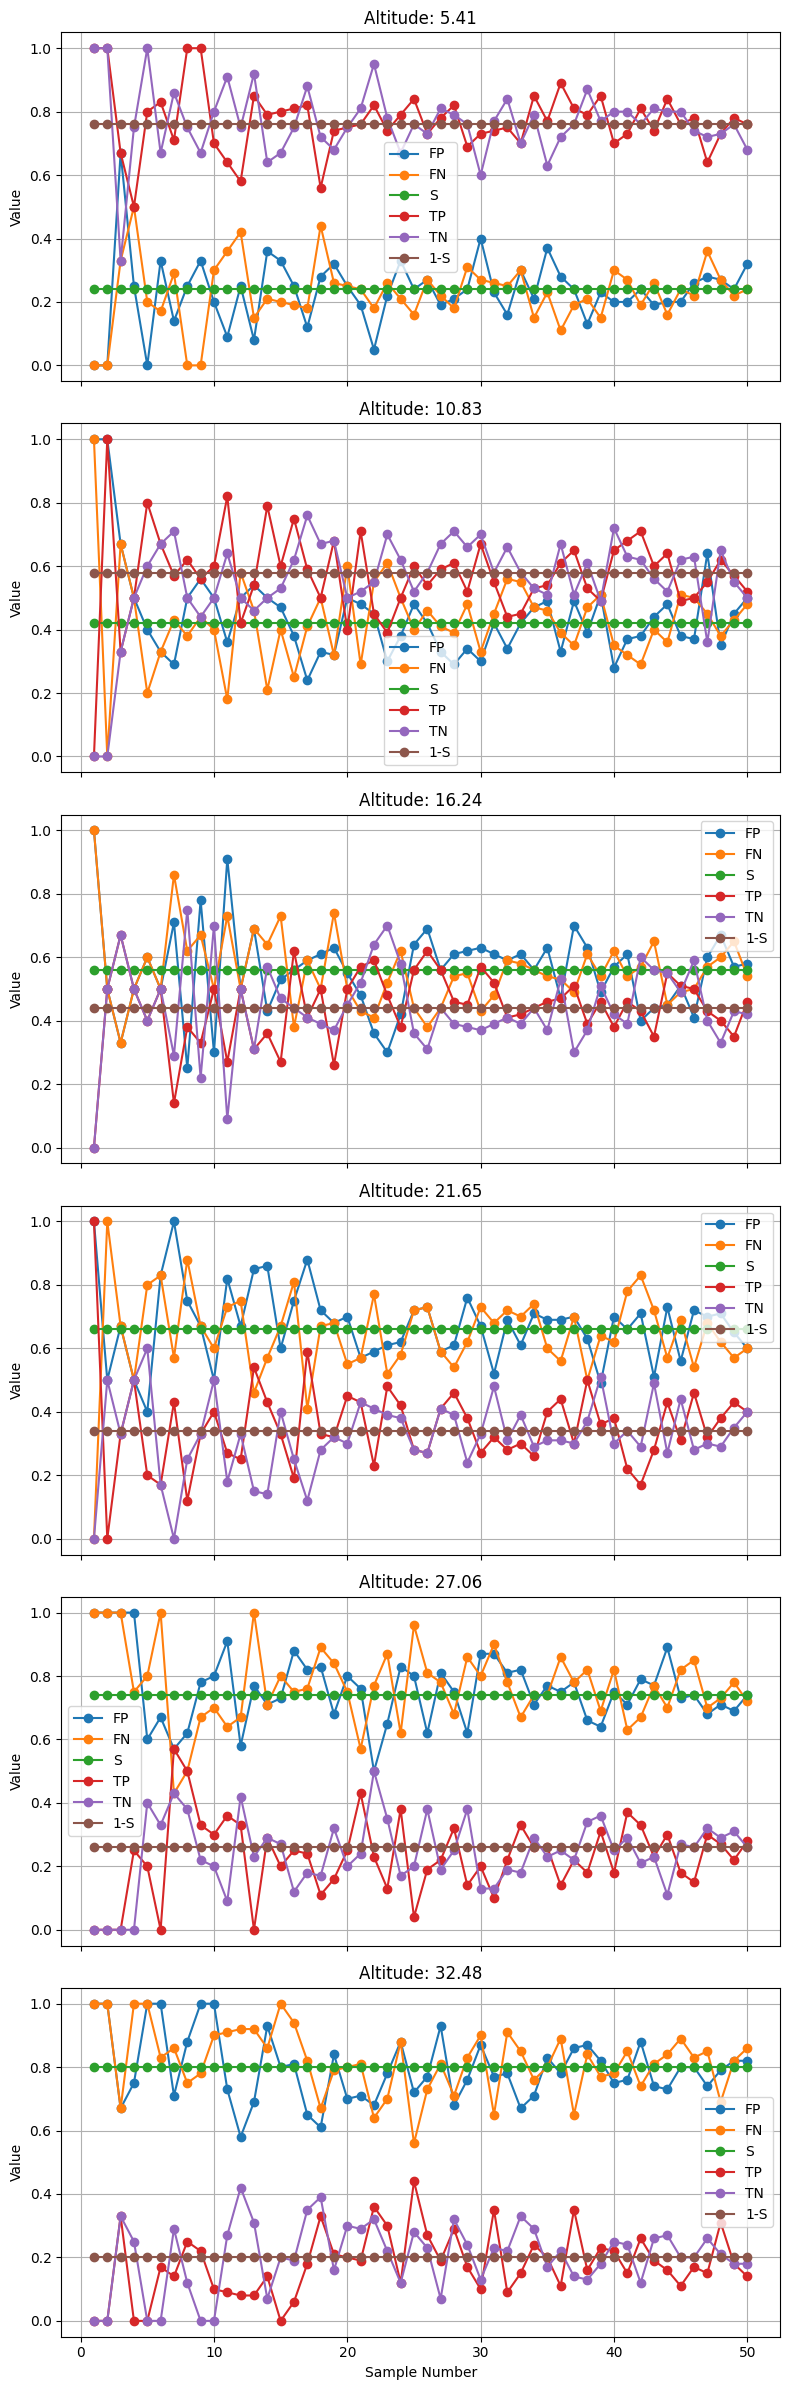

In [139]:

# Prepare data for plotting
altitudes = list(all_data.keys())

# Create subplots for each altitude
fig, axes = plt.subplots(len(altitudes), 1, figsize=(8, 4 * len(altitudes)), sharex=True)

# Ensure axes is iterable
if len(altitudes) == 1:
    axes = [axes]

# Plot for each altitude
for idx, altitude in enumerate(altitudes):
    samples = all_data[altitude]
    sample_numbers = sorted(samples.keys())
    
    # Extract values for FP, FN, S, TP, TN, and 1-S
    FP = [samples[n]['FP'] for n in sample_numbers]
    FN = [samples[n]['FN'] for n in sample_numbers]
    S = [samples[n]['S'] for n in sample_numbers]
    TP = [samples[n]['TP'] for n in sample_numbers]
    TN = [samples[n]['TN'] for n in sample_numbers]
    one_minus_S = [samples[n]['1-S'] for n in sample_numbers]
    
    # Plot FP, FN, S, TN, TP, and 1-S
    ax = axes[idx]
    ax.plot(sample_numbers, FP, label='FP', marker='o')
    ax.plot(sample_numbers, FN, label='FN', marker='o')
    ax.plot(sample_numbers, S, label='S', marker='o')
    ax.plot(sample_numbers, TP, label='TP', marker='o')
    ax.plot(sample_numbers, TN, label='TN', marker='o')
    ax.plot(sample_numbers, one_minus_S, label='1-S', marker='o')
    
    ax.set_title(f'Altitude: {altitude}')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend(loc='best')

# Set common x-label
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()
